In [2]:
import os
import sys
import inspect

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath("__file__")))))


import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize
from tqdm.autonotebook import tqdm
from copy import deepcopy
from cka import CKACalculator



In [3]:
def select_2(num:int = 0):
    assert(num>=2)
    result = []
    used_only_one = []
    combi = int(num*(num-1)/2)
    one_el_true_num = num - 1
    used_never = list(range(combi))
    for i in range(combi):
        result.append([False] * num)
        
    for j in range(num):
        
        for n in used_only_one:
            use_second = n.pop(0)

            result[use_second][j] = True
        this_use_first = []
        for o in range(one_el_true_num - len(used_only_one)):
            use_first = used_never.pop(0)
            this_use_first.append(use_first)
            result[use_first][j] = True
        used_only_one.append(this_use_first)

        
        
    return result
        
        
        

In [4]:
select_2(5)

[[True, True, False, False, False],
 [True, False, True, False, False],
 [True, False, False, True, False],
 [True, False, False, False, True],
 [False, True, True, False, False],
 [False, True, False, True, False],
 [False, True, False, False, True],
 [False, False, True, True, False],
 [False, False, True, False, True],
 [False, False, False, True, True]]

In [5]:
import torch
z = torch.tensor(list(range(5)))
for k in select_2(5):
    #print(k)
    print(z[k])




tensor([0, 1])
tensor([0, 2])
tensor([0, 3])
tensor([0, 4])
tensor([1, 2])
tensor([1, 3])
tensor([1, 4])
tensor([2, 3])
tensor([2, 4])
tensor([3, 4])


In [6]:
[1,4][True,False]

<>:1: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
<>:1: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
/tmp/ipykernel_91173/325484639.py:1: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  [1,4][True,False]


TypeError: list indices must be integers or slices, not tuple

In [7]:
[True]*4

[True, True, True, True]

In [8]:
x_choose_2(4)

NameError: name 'x_choose_2' is not defined

## Setup DataLoader and Models 

An important detail is that although we are using the Validation set for `CIFAR10`, we **shuffle** and drop the last batch. This is to ensure that 1) the batches of each epoch are mixed, and 2) each iteration has the same batch size.

In [9]:
transforms = Compose([ToTensor(), 
                      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

dataset = CIFAR10(root='../data', train=False, download=True, transform=transforms)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)

Files already downloaded and verified


In [10]:
dataloader.batch_size






256

In [11]:
#dir(dataloader.dataset.shuffle)
print(type(dataloader.sampler))

dataloader2 = DataLoader(dataset, batch_size=256, shuffle=False, drop_last=True, num_workers=4, pin_memory=True)
print(type(dataloader2.sampler))
for i in dataloader2.sampler:
    print(i)

<class 'torch.utils.data.sampler.RandomSampler'>
<class 'torch.utils.data.sampler.SequentialSampler'>
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251


In [12]:
import os
import sys
import inspect

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath("__file__")))))
from models import ResNet18_GFLN

In [13]:
model1 = ResNet18_GFLN().cuda()
model1.eval()
model2 = deepcopy(model1)
model2.eval()
print('Dummy models created')

Dummy models created


## Compute CKA 

In [15]:
from cka import CKACalculator

### Basic Usage 

Initializing the `CKACalculator` object will add forward hooks to both `model1` and `model2`. 
The default modules that are hooked are: `Bottleneck`, `BasicBlock`, `Conv2d`, `AdaptiveAvgPool2d`, `MaxPool2d`, and all instances of `BatchNorm`. 
Note that `Bottleneck` and `BasicBlock` are from the `torchvision` implementation, and will not add hooks to any custom implementations of `Bottleneck/BasicBlock`.

For ResNet18, a total of 50 hooks are added.

By default, the intermediate features are flattened with `flatten_hook_fn` and 10 epochs are run.

In [16]:
calculator = CKACalculator(model1=model1, model2=model2, dataloader=dataloader, num_epochs = 1)

No hook function provided. Using flatten_hook_fn.
48 Hooks registered. Total hooks: 48
No hook function provided. Using flatten_hook_fn.
48 Hooks registered. Total hooks: 48


In [17]:
(model1.state_dict().keys())

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', 'layer2.0.downsample.0.weight', 'layer2.0.downsample.1.weight', 'layer2.0.downsample.1.bias', 'layer2.1.conv1.weight', 'layer2.1.bn1.weight', 'layer2.1.bn1.bias', 'layer2.1.conv2.weight', 'layer2.1.bn2.weight', 'layer2.1.bn2.bias', 'layer3.0.conv1.weight', 'layer3.0.bn1.weight', 'layer3.0.bn1.bias', 'layer3.0.conv2.weight', 'layer3.0.bn2.weight', 'layer3.0.bn2.bias', 'layer3.0.downsample.0.weight', 'layer3.0.downsample.1.weight', 'layer3.0.downsample.1.bias', 'layer3.1.conv1.weight', 'layer3.1.bn1.weight', 'layer3.1.bn1.bias',

In [18]:
count = 0
for key in (model1.state_dict().keys()):
    if 'bn' in key:
        count+=1
print(count)

34


Now we can calculate the CKA matrix 

In [19]:
cka_output = calculator.calculate_cka_matrix()
print(f"CKA output size: {cka_output.size()}")

Epoch 0:   0%|          | 0/39 [00:00<?, ?it/s]

CKA output size: torch.Size([48, 48])


#### Visualize the output

Note that the returned matrix has its origin at the top left. In most papers, the CKA matrix is visualized with its origin at the bottom left. Thus, we may flip the matrix first before visualization; however, this example chooses not to.

In [20]:
import matplotlib.pyplot as plt


In [23]:
print(cka_output.shape)

torch.Size([48, 48])


In [57]:
import numpy as np
diag = (torch.diagonal(cka_output)) 
diag = diag - torch.rand(diag.shape).to(diag.device)
print(diag.shape)
print(diag.cpu().numpy().shape)
print(np.arange(len(diag)).shape)
print(diag)
print(len(diag))
#print((range(len(diag)).shape))

torch.Size([48])
(48,)
(48,)
tensor([0.0323, 0.8822, 0.4141, 0.5520, 0.4012, 0.2468, 0.3094, 0.1224, 0.3899,
        0.2409, 0.2980, 0.4149, 0.6561, 0.8251, 0.3183, 0.8137, 0.7730, 0.3680,
        0.7758, 0.2292, 0.3430, 0.7565, 0.6327, 0.2237, 0.6729, 0.1104, 0.8877,
        0.5315, 0.2427, 0.0204, 0.7464, 0.9634, 0.7499, 0.1250, 0.3584, 0.0266,
        0.4999, 0.5594, 0.2742, 0.7789, 0.9959, 0.6142, 0.7656, 0.4656, 0.6783,
        0.5086, 0.0429, 0.2702], device='cuda:0')
48


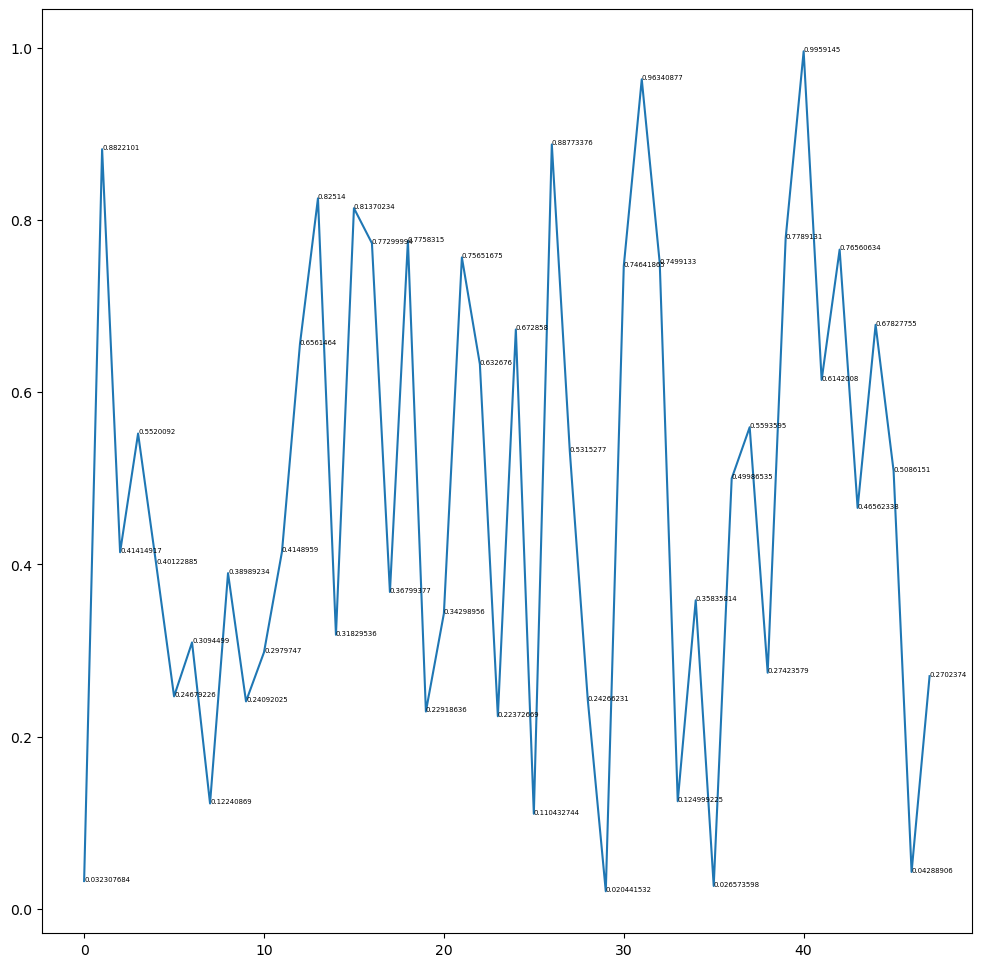

In [59]:
plt.rcParams['figure.figsize'] = (12, 12)
x, y = np.arange(len(diag)),diag.cpu().numpy()
plt.plot(x,y)
for xx,yy in zip(x,y):
    plt.text(xx,yy,str(yy),fontsize = 5)
plt.show()

<class 'module'>
<class 'matplotlib.image.AxesImage'>


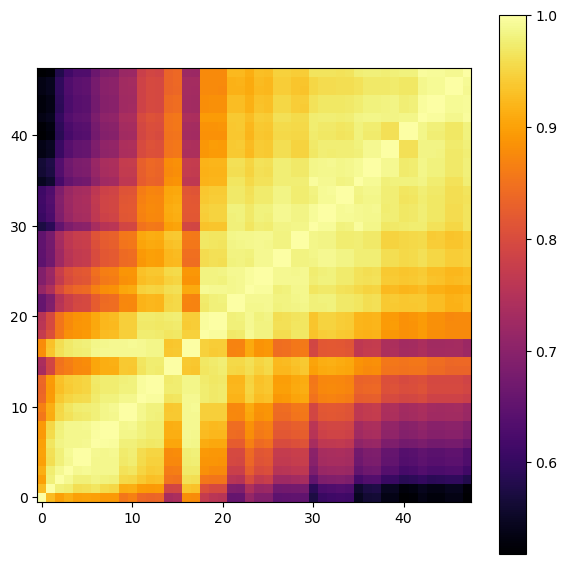

In [63]:
plt.rcParams['figure.figsize'] = (7, 7)
axes = plt.imshow(cka_output.cpu().numpy(), cmap='inferno')
axes.axes.invert_yaxis()
plt.colorbar()
print(type(plt))
print(type(axes))

In [ ]:
#Extract module names
for i, name in enumerate(calculator.module_names_X):
    print(f"Layer {i}: \t{name}")

Layer 0: 	conv1
Layer 1: 	bn1
Layer 2: 	layer1.0.conv1
Layer 3: 	layer1.0.bn1
Layer 4: 	layer1.0.conv2
Layer 5: 	layer1.0.bn2
Layer 6: 	layer1.0
Layer 7: 	layer1.1.conv1
Layer 8: 	layer1.1.bn1
Layer 9: 	layer1.1.conv2
Layer 10: 	layer1.1.bn2
Layer 11: 	layer1.1
Layer 12: 	layer2.0.conv1
Layer 13: 	layer2.0.bn1
Layer 14: 	layer2.0.conv2
Layer 15: 	layer2.0.bn2
Layer 16: 	layer2.0.downsample.0
Layer 17: 	layer2.0.downsample.1
Layer 18: 	layer2.0
Layer 19: 	layer2.1.conv1
Layer 20: 	layer2.1.bn1
Layer 21: 	layer2.1.conv2
Layer 22: 	layer2.1.bn2
Layer 23: 	layer2.1
Layer 24: 	layer3.0.conv1
Layer 25: 	layer3.0.bn1
Layer 26: 	layer3.0.conv2
Layer 27: 	layer3.0.bn2
Layer 28: 	layer3.0.downsample.0
Layer 29: 	layer3.0.downsample.1
Layer 30: 	layer3.0
Layer 31: 	layer3.1.conv1
Layer 32: 	layer3.1.bn1
Layer 33: 	layer3.1.conv2
Layer 34: 	layer3.1.bn2
Layer 35: 	layer3.1
Layer 36: 	layer4.0.conv1
Layer 37: 	layer4.0.bn1
Layer 38: 	layer4.0.conv2
Layer 39: 	layer4.0.bn2
Layer 40: 	layer4.0.downsa

### Advanced Usage 

We can customize other parameters of the `CKACalculator`. 
Most importantly, we can select which modules to hook. 

Before instantiating a new instance of `CKACalculator` on, make sure to first call the `reset` method. 
This clears all hooks registered in the models.

In [ ]:
# Reset calculator to clear hooks
calculator.reset()
torch.cuda.empty_cache()

50 handles removed.
50 handles removed.


In [ ]:
import torch.nn as nn

Let's consider outputs of `Conv2d` and `BatchNorm2d` only. This will create 40 hooks.

For custom layers, add the custom modules in the same manner as shown below.

In [ ]:
layers = (nn.Conv2d, nn.BatchNorm2d)

In [ ]:
calculator = CKACalculator(model1=model1, model2=model2, dataloader=dataloader, hook_layer_types=layers)

No hook function provided. Using flatten_hook_fn.
40 Hooks registered. Total hooks: 40
No hook function provided. Using flatten_hook_fn.
40 Hooks registered. Total hooks: 40


In [ ]:
cka_output = calculator.calculate_cka_matrix()

Epoch 0:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/39 [00:00<?, ?it/s]

#### Visualize output 

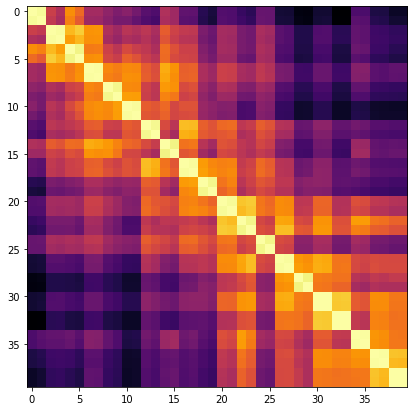

In [ ]:
plt.imshow(cka_output.cpu().numpy(), cmap='inferno')

#### Extract module names 

In [ ]:
for i, name in enumerate(calculator.module_names_X):
    print(f"Layer {i}: \t{name}")

Layer 0: 	conv1
Layer 1: 	bn1
Layer 2: 	layer1.0.conv1
Layer 3: 	layer1.0.bn1
Layer 4: 	layer1.0.conv2
Layer 5: 	layer1.0.bn2
Layer 6: 	layer1.1.conv1
Layer 7: 	layer1.1.bn1
Layer 8: 	layer1.1.conv2
Layer 9: 	layer1.1.bn2
Layer 10: 	layer2.0.conv1
Layer 11: 	layer2.0.bn1
Layer 12: 	layer2.0.conv2
Layer 13: 	layer2.0.bn2
Layer 14: 	layer2.0.downsample.0
Layer 15: 	layer2.0.downsample.1
Layer 16: 	layer2.1.conv1
Layer 17: 	layer2.1.bn1
Layer 18: 	layer2.1.conv2
Layer 19: 	layer2.1.bn2
Layer 20: 	layer3.0.conv1
Layer 21: 	layer3.0.bn1
Layer 22: 	layer3.0.conv2
Layer 23: 	layer3.0.bn2
Layer 24: 	layer3.0.downsample.0
Layer 25: 	layer3.0.downsample.1
Layer 26: 	layer3.1.conv1
Layer 27: 	layer3.1.bn1
Layer 28: 	layer3.1.conv2
Layer 29: 	layer3.1.bn2
Layer 30: 	layer4.0.conv1
Layer 31: 	layer4.0.bn1
Layer 32: 	layer4.0.conv2
Layer 33: 	layer4.0.bn2
Layer 34: 	layer4.0.downsample.0
Layer 35: 	layer4.0.downsample.1
Layer 36: 	layer4.1.conv1
Layer 37: 	layer4.1.bn1
Layer 38: 	layer4.1.conv2
Laye